In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
from sklearn.isotonic import IsotonicRegression

In [2]:
ls ../uuss_data/p_resampled

uuss_NGB_4s_1dup.h5  uuss_test_fewerhist_4s_1dup.h5  uuss_train.csv
uuss_NGB.csv         uuss_test_fewerhist.csv         uuss_validation_4s_1dup.h5
uuss_test.csv        uuss_train_4s_1dup.h5           uuss_validation.csv


In [3]:
def load_model_results(file_name):
    file = np.load(file_name)
    predictions = file["predictions"]
    targets = file["targets"][:, 0]
    pred_mean = file["prediction_mean"]
    pred_std = file["prediction_std"]
    resids = targets - pred_mean

    return predictions, pred_mean, pred_std, targets, resids

def load_subset_model_results(file_name, i):
    file = np.load(file_name)
    predictions = file["predictions"][:, 0:i]
    targets = file["targets"][:, 0]
    pred_mean = np.mean(predictions, axis=1)
    pred_std = np.std(predictions, axis=1)
    resids = targets - pred_mean

    return predictions, pred_mean, pred_std, targets, resids

def make_prediction_df(means, stds, targets, residuals):
    # Combine into a dataframe
    df_data = {"y_pred":means, "std":stds, "y_act":targets, "residual":residuals}
    df = pd.DataFrame(data=df_data)
    df.head()

    return df

# Accurate Uncertainties for Deep Learning Using Calibrated Regression
Recalibration dataset $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$
1. Compute $F_t$ = CDF[$N(\mu_t, \sigma^2_t)]$ for t $\in$ [1, T]
2. Evalute $F_t(y_t)$ for t $\in$ [1, T]
3. compute $\hat{P}(p)=\frac{| \{y_t | F_t(y_t) \leq p, t=1...,T \}|}{T}$, where $p=F_t(y_t)$ for t $\in$ [1, T]

Fit Isotonic Regression model R to D

- Fitting regression model to D' = $\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ seems easier for adjusting the "standard deviation" to be calibrated.
- When using D, will need to compute the CDF of the Gaussian with predicted $\mu$ and $\sigma$, transform with R, and then invert for $x_{lb}$ and $x_{ub}$. Since the CDF has been transformed, norm.ppf can no longer be used to invert. 
- When using D', can compute the ppf of the gaussian with predicted $\mu$ and $\sigma$ and evaluate it at R(lb) and R(ub). 
- I show below that $x_{lb}$ and $x_{ub}$ computed using the D' method intersect with the transformed CDF computed using D at 0.16 and 0.84. 

## Fit Predicted vs Empirical Curve $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$ with Isotonic Regression

In [4]:
# Do steps 1 & 2
def eval_cdf(df):
    df["cdf"] = df.apply(lambda x: norm.cdf(x["y_act"], x["y_pred"], x["std"]), axis=1)
    print(df.head())

In [5]:
# Do step 3
def plot_empirical_cdf(df, swap_xy=False):
    fig = plt.figure()
    plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--", label="Perfect Calibration")
    if not swap_xy:
        plt.scatter(df.cdf.values, df.p_hat.values, alpha=0.1)
        plt.ylabel("Empirical Cumulative Distribution")
        plt.xlabel("Predicted Cumulative Distribution")
    else:
        plt.scatter(df.p_hat.values, df.cdf.values, alpha=0.1)
        plt.xlabel("Empirical Cumulative Distribution")
        plt.ylabel("Predicted Cumulative Distribution")
    plt.title("Estimating Cumulative Density of Forecast")
    plt.legend();
    plt.show()
    
def compute_empirical_cdf(df, swap_xy=False):
    p_hat = []
    T = len(df)
    for index, row in df.iterrows():
        p = row["cdf"]
        p_hat.append((df["cdf"] <= p).sum()/T)
    df["p_hat"] = p_hat

    #plot_empirical_cdf(df, swap_xy)

In [6]:
def check_nondecreasing(df):
    assert ~np.any(np.diff(df.sort_values("cdf")["p_hat"].values) < 0), "CDF vs P_Hat is not non-decreasing"
    assert ~np.any(np.diff(df.sort_values("p_hat")["cdf"].values) < 0), "P_Hat vs CDF is not non-decreasing"

In [7]:
def plot_calibration_curves(df, regressors, title, swap_xy=False):
    
    plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
    colors = plt.cm.viridis(np.linspace(0,1,len(regressors)))
    for i in range(len(regressors)):
        regressor = regressors[i]
        p_hat_cal = []
        p_hat_uncal = []
        T = len(df)
        for p in np.arange(0, 1.05, 0.05):
            if swap_xy:
                p_hat_cal.append((df.cdf <= regressor.predict([p])[0]).sum()/T)
            else:
                p_hat_cal.append((regressor.predict(df.cdf) <= p).sum()/T)

            p_hat_uncal.append((df["cdf"] <= p).sum()/T)

        #plt.plot(np.arange(0, 1.05, 0.05), p_hat_cal, marker="o", label="calibrated")
        plt.plot(np.arange(0, 1.05, 0.05), p_hat_uncal, color=colors[i], linewidth=0.5)
#    plt.legend()
    plt.title(title)

## Fit Empirical vs Predicted Curve $D=\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ with Isotonic Regression

In [27]:
def compute_p_hats(epochs, file_pref):
    all_p_hat_uncal = []
    for e in epochs:
        p_hat_uncal = []
        cdf_vals = []
        for samples in range(5, 51):
            val_preds, val_pred_mean, val_pred_std, val_targets, val_resids = load_subset_model_results(f"{file_pref}_{e}.npz", i=samples)
            val_df = make_prediction_df(val_pred_mean, val_pred_std, val_targets, val_resids)
            eval_cdf(val_df)
            T = len(val_df)
            df_val_p_hat = []
            for p in np.arange(0, 1.05, 0.05):
                 df_val_p_hat.append((val_df["cdf"] <= p).sum()/T)        
            p_hat_uncal.append(df_val_p_hat)
        all_p_hat_uncal.append(p_hat_uncal)
        
    return all_p_hat_uncal

In [28]:
all_p_hat_uncal_large = compute_p_hats([62], f"seed1_128_0.0005_5e-3_0.0002_61_26_20/eval_50/swag_validation_uncertainty")

     y_pred       std  y_act  residual       cdf
0  0.311905  0.102215   0.32  0.008095  0.531563
1  0.209128  0.066511   0.20 -0.009128  0.445420
2  0.424415  0.152176   0.43  0.005585  0.514639
3  0.461054  0.130787   0.45 -0.011054  0.466322
4  0.269970  0.087424   0.18 -0.089970  0.151711
     y_pred       std  y_act  residual       cdf
0  0.334669  0.106290   0.32 -0.014669  0.445118
1  0.162437  0.120775   0.20  0.037563  0.622106
2  0.478679  0.184447   0.43 -0.048679  0.395921
3  0.505347  0.155125   0.45 -0.055347  0.360625
4  0.318023  0.133844   0.18 -0.138023  0.151219
     y_pred       std  y_act  residual       cdf
0  0.289758  0.147600   0.32  0.030242  0.581173
1  0.142831  0.121693   0.20  0.057169  0.680744
2  0.410268  0.239252   0.43  0.019732  0.532865
3  0.431820  0.230355   0.45  0.018180  0.531452
4  0.274589  0.163323   0.18 -0.094589  0.281244
     y_pred       std  y_act  residual       cdf
0  0.247701  0.177323   0.32  0.072299  0.658261
1  0.126480  0.12177

     y_pred       std  y_act  residual       cdf
0  0.205364  0.181129   0.32  0.114636  0.736600
1  0.126904  0.136614   0.20  0.073096  0.703693
2  0.334211  0.274519   0.43  0.095789  0.636430
3  0.342248  0.294162   0.45  0.107752  0.642930
4  0.194275  0.160401   0.18 -0.014275  0.464543
     y_pred       std  y_act  residual       cdf
0  0.209992  0.180416   0.32  0.110008  0.728985
1  0.130583  0.136239   0.20  0.069417  0.694807
2  0.339031  0.271865   0.43  0.090969  0.631041
3  0.352591  0.295831   0.45  0.097409  0.629026
4  0.196602  0.158589   0.18 -0.016602  0.458313
     y_pred       std  y_act  residual       cdf
0  0.209935  0.177820   0.32  0.110065  0.732031
1  0.133385  0.135269   0.20  0.066615  0.688805
2  0.343904  0.269456   0.43  0.086096  0.625333
3  0.356594  0.292507   0.45  0.093406  0.625261
4  0.197419  0.156380   0.18 -0.017419  0.455653
     y_pred       std  y_act  residual       cdf
0  0.214495  0.177396   0.32  0.105505  0.723993
1  0.132199  0.13356

In [21]:
def plot_uncalibrated_curves(all_p_hat_uncal, title):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
    ax[0].plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
    colors = plt.cm.viridis(np.linspace(0,1,len(all_p_hat_uncal)))
    for i in range(len(all_p_hat_uncal)):
        ax[0].plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[i], color=colors[i], linewidth=0.5)
    
    #ax[0].plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[22], color="red", linewidth=1.0)
    ax[0].plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[10], color="red", linewidth=1.0)

    ax[0].set_title(title)
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Empirical")
    ax[1].imshow([colors])
    ax[1].set_xlabel("N samples")
    plt.yticks([])

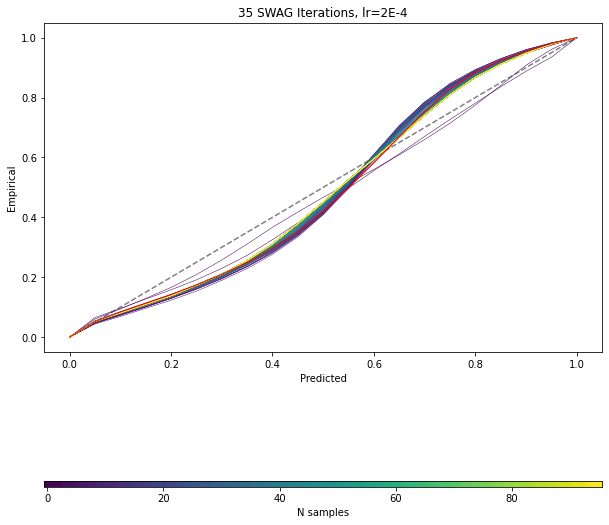

In [22]:
plot_uncalibrated_curves(all_p_hat_uncal_large[0], title="35 SWAG Iterations, lr=2E-4")

In [25]:
len(all_p_hat_uncal_large[0])

96

In [26]:
np.load(f"seed1_128_0.0005_5e-3_0.0002_61_26_20/eval_50/swag_validation_uncertainty_62.npz")